# Docking score distributions

This notebook visualizes the docking score distributions of docking poses generated by Fred, Hybrid and Posit and selected by 2D similarity, 3D similarity, docking score and Posit probability. All docking scores higher than 50 are set to 50 to allow proper visualization of outliers in case of Posit.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)

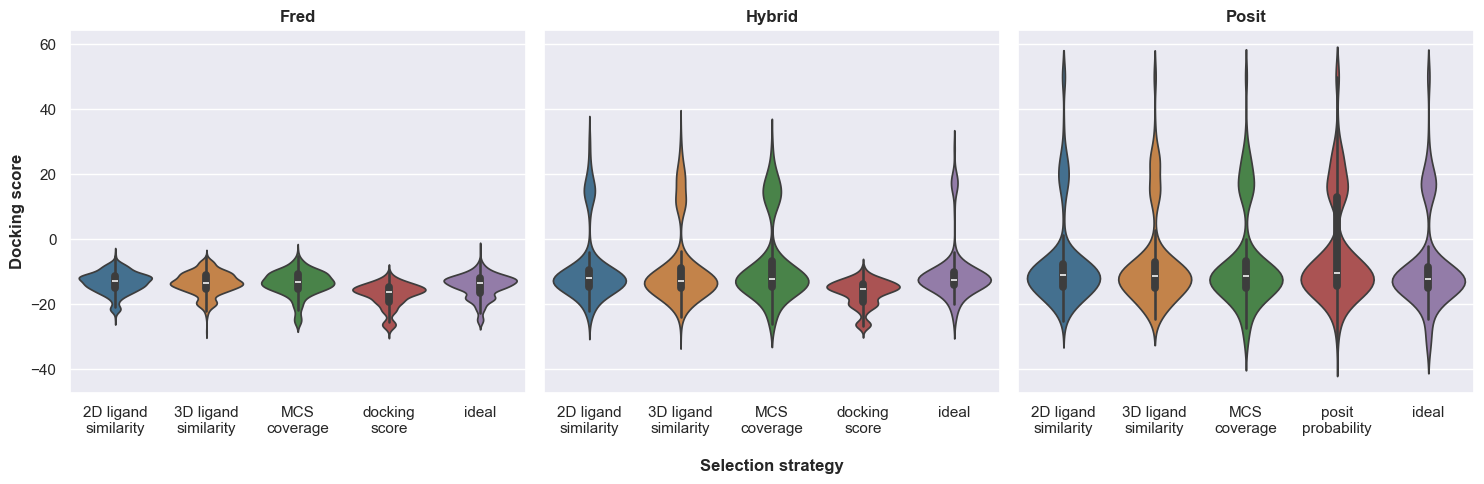

In [5]:
def plot_docking_score_distributions(fred_results, hybrid_results, posit_results, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]    
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 3 subplots
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
    
    # collect data for single dataframe
    for i, (method, results) in enumerate(zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results])):
        data_collection = []
        for selection_strategy in ["2D ligand similarity", "3D ligand similarity", "MCS coverage", "score/probability", "ideal"]:
            if selection_strategy == "2D ligand similarity":
                selected_results = results.sort_values("fingerprint_similarity", ascending=False)
            elif selection_strategy == "3D ligand similarity":
                selected_results = results.sort_values("shape_similarity", ascending=False)
            elif selection_strategy == "score/probability":
                selected_results = results.sort_values("docking_score")
                if method == "Posit":
                    selected_results = selected_results.sort_values("posit_probability", ascending=False)
            if selection_strategy == "MCS coverage":
                selected_results = results.sort_values("mcs_coverage", ascending=False)
            elif selection_strategy == "ideal":
                selected_results = results.sort_values("rmsd")
            selected_results = selected_results.groupby(["ligand_pdb_id"]).head(1)
            # cutoff of 50 to be able to visualize outliers from Posit
            data_collection += [[selection_strategy, docking_score] if docking_score < 50 else [selection_strategy, 50] for docking_score in selected_results["docking_score"]]
            
        # create dataframe and plot
        data_collection = pd.DataFrame(data_collection, columns=["method", "docking_score"])
        sns.violinplot(x="method", y="docking_score", data=data_collection, palette="tab10", saturation=0.5, ax=axes[i])
        axes[i].set_title(method, fontweight="bold")
        axes[i].set_xticklabels(["2D ligand\nsimilarity", "3D ligand\nsimilarity", "MCS\ncoverage", "docking\nscore", "ideal"])
        if method == "Posit":
            axes[i].set_xticklabels(["2D ligand\nsimilarity", "3D ligand\nsimilarity", "MCS\ncoverage", "posit\nprobability", "ideal"])
        if i == 1:
            axes[i].set_xlabel("\nSelection strategy", fontweight="bold")
        else:
            axes[i].set_xlabel("", fontweight="bold")
        if i == 0:
            axes[i].set_ylabel("Docking score", fontweight="bold")
        else:
            axes[i].set_ylabel("", fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(directory / "docking_score_distributions.pdf", dpi=300)
        
    return


plot_docking_score_distributions(fred_results, hybrid_results, posit_results)